<a href="https://colab.research.google.com/github/AmirhosseinnnKhademi/GEN-AI---TF/blob/main/tutorials/generative/Convolutional_Variational_AutoEncoder/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

![CVAE image latent space](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cvae_latent_space.jpg?raw=1)

## Setup

In [34]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-a7b6jhxp
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-a7b6jhxp
  Resolved https://github.com/tensorflow/docs to commit a81ff2e4ebf518b45cad643d88063c6f2b9e5a1e
  Preparing metadata (setup.py) ... done


In [35]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [36]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
# The line (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data() loads the MNIST dataset.
# It returns tuples for training and testing images (and their labels, which are ignored here using _).

In [37]:
# Reshape & Normalize: It reshapes the images from (num_samples, 28, 28) to (num_samples, 28, 28, 1) to add a channel dimension (grayscale)
# and divides the pixel values by 255 to scale them between 0 and 1.

# Binarize: It then converts these normalized pixel values to binary values (0 or 1) by setting any pixel with a value greater than 0.5 to 1 and the rest to 0.

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [38]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [39]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# tf.data.Dataset.from_tensor_slices(train_images) converts the train_images array into a dataset, where each element is one image.
# Simply to say; the code creates a dataset where each individual image from train_images becomes a separate data point in the dataset.

# The .shuffle(train_size) method randomly shuffles the dataset

# The .batch(batch_size) method groups the images into batches of size batch_size. Batching helps in efficient computation and gradient estimation during training.

1. The Overall Idea of a VAE
Variational Autoencoder (VAE):
A VAE is a generative model that learns to represent input data (like images) in a lower-dimensional latent space (denoted by z), and then reconstructs or generates data from this space. It has two main parts:

* Encoder (Inference/Recognition Model): Maps an observation x (e.g., an image) to a latent representation z.
* Decoder (Generative Model): Maps a latent variable z back to the observation space to generate or reconstruct an image.
---
2. Encoder Network
* Purpose:
The encoder approximates the posterior distribution q(z|x). It takes an input image x and outputs the parameters of a diagonal (i.e., factorized) Gaussian distribution:

 * Mean (μ)
 * Log-variance (logσ²)

* Why Log-Variance?
Instead of outputting the variance directly, the network outputs the log-variance for numerical stability. This helps when you later compute the standard deviation (σ) as the exponential of half the log-variance.

* Architecture Details:
The encoder typically uses:

 * Convolutional Layers: Two small ConvNet layers extract spatial features from the image.
 * Fully-Connected Layer: This layer converts the features into a flat vector, which then outputs the parameters (mean and log-variance) for the latent variable z.
---
3. Decoder Network
* Purpose:
The decoder models the conditional distribution p(x|z). It takes a latent sample z as input and outputs parameters that define a distribution over images (typically modeling pixel intensities).

* Architecture Details:
The decoder is essentially a mirror of the encoder:
 * Fully-Connected Layer: Starts by expanding the latent vector z into a higher-dimensional representation.
 * Convolution Transpose Layers: (Also known as deconvolutional layers) These layers gradually reconstruct the spatial dimensions of the image, effectively “undoing” the convolution process of the encoder.
* Latent Distribution Prior:
The prior p(z) is usually assumed to be a unit Gaussian (i.e., a standard normal distribution).
---
4. Reparameterization Trick
* The Challenge:
When you sample z directly from the distribution defined by the encoder (i.e., from $q(z|x)$), the random sampling process prevents gradients from flowing through the network during backpropagation.

* The Trick:
To overcome this, we reparameterize the sample z as follows:
$z=μ+σ⊙ϵ$

 Here:

 * μ (mu): Mean of the Gaussian.
 * σ (sigma): Standard deviation, which is computed from the log-variance.
 * ϵ (epsilon): Random noise sampled from a standard normal distribution.

 This reformulation makes the sampling process differentiable with respect to μ and σ, since ϵ is independent of the network parameters. In other words, the randomness is isolated in ϵ, allowing gradients to flow back through μ and σ during training.
---
In Summary

* Encoder:
 * Maps image x to latent parameters (mean μ and log-variance logσ²).
 * Uses convolutional layers for feature extraction and a dense layer for output.

* Decoder:

 * Maps latent sample z to the image space to reconstruct/generate images.
 * Uses a dense layer to expand z followed by convolution transpose layers to rebuild the image.

* Reparameterization Trick:
 * Allows the network to sample z in a differentiable way by computing $z = μ + σ × ϵ$, where ϵ is noise from a standard normal distribution.

This approach provides a clear and structured method to both encode the input into a latent space and decode it back, while ensuring that the stochastic elements of the model can be trained via backpropagation.

Posterior Distribution $q(z∣x)$:

* Definition: $q(z∣x)$ is the distribution over latent variables $z$ given an observed data point $x$. In other words, it represents our "belief" about what latent variables could have generated the observed data.


Conditional Distribution $p(x∣z)$:

* Definition: $p(x∣z)$ is the distribution over the observed data $x$ given a latent variable $z$. It tells us how likely it is to observe $x$ if we assume a particular latent representation $z$.

In [40]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)), # The encoder accepts images with shape (28, 28, 1) (28×28 pixels, 1 channel for grayscale).
            # The first layer uses 32 filters, a 3×3 kernel, and strides of (2, 2), reducing spatial dimensions while applying a ReLU activation. (14 x 14)
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            # # The second layer uses 64 filters, a 3×3 kernel, and strides of (2, 2), reducing spatial dimensions while applying a ReLU activation. (7 x 7)
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            # flattens the 7 x 7 x 64 output into a 1D vector.
            tf.keras.layers.Flatten(),
            # A dense layer follows, outputting latent_dim + latent_dim units.
            # The first half represents the mean (μ) of the Gaussian.
            # The second half represents the log-variance (logσ²) of the Gaussian.
            # No activation: It outputs raw values, which is common when predicting distribution parameters.
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)), # Specifies that the decoder accepts a latent vector of shape (latent_dim,).
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            # A dense layer expands the latent vector to 7×7×32 units (activating with ReLU),
            # The 7×7 part is chosen to match the spatial dimensions that resulted from the encoder’s convolutional reductions.
            # The 32 channels are a design choice to create an intermediate representation.
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            # the reshape, converts the 7x7x32 = 1568 unit vector, into a 3D tensor of shape 7, 7, 32, preparing it for the deconvolution (upsampling).
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # Upsampling: Increases spatial dimensions (roughly from 7x7 to 14x14)
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # Upsampling: Increases spatial dimensions (roughly from 14x14 to 28x28)
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            # Produces an output with 1 channel (matching the original image's grayscale format)
            # without an activation function. The output here is the logits for the reconstructed image.
        ]
    )

  @tf.function
  # Purpose: Generates new samples from the latent space.
  # If no noise 𝜖 is provided, it generates 100 samples from a standard normal distribution.
  # These samples are then passed through the decoder (with sigmoid applied) to produce reconstructed images.
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  # Passes the input image x through the encoder network.
  # Output: Uses tf.split to divide the output vector into two parts: mean and log-variance for the latent distribution q(z|x)
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # Purpose: Implements the reparameterization trick to allow gradients to flow through the stochastic sampling process.
  # Generates random noise 𝜖 from a standard normal distribution.
  # Computes z = eps * tf.exp(logvar * .5) + mean
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  # Maps a latent vector 𝑧 back to the image space using the decoder.
  # If apply_sigmoid is True, applies the sigmoid function to the logits to get probability values for each pixel (useful when the images are modeled as Bernoulli distributions).
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

**HOW TO CALCULATELOSS TERMS**

1- Reconstruction Term: $logp(x∣z)$

Measures how well the decoder can reconstruct the original image $x$ from the latent sample $z$.

Since the pixels of $x$ are modeled as Bernoulli random variables (binary values), we use the sigmoid cross-entropy loss:

`cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)`

this computes the binary cross-entropy for each pixel. Thus, The cross-entropy is summed over all pixel dimensions:

`logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])`

---
2- Prior Term: $logp(z)$:
Measures how likely the sampled $z$ is under the prior distribution, which is assumed to be a standard normal distribution $N(0,I)$.

The helper function log_normal_pdf computes the log probability density for a Gaussian.

For the prior, we pass in mean=0. and logvar=0. which correspond to a standard normal distribution (since $log(1)=0$):

`logpz = log_normal_pdf(z, 0., 0.)`

This term sums the log probability of each dimension of $z$ under the $N(0,1)$ distribution.

---

Posterior Term: $log  q(z∣x)$
Measures the log probability of the latent sample $z$ under the approximate posterior distribution $q(z∣x)$, as defined by the encoder.

The encoder outputs the mean and log-variance for $q(z∣x)$:

`mean, logvar = model.encode(x)`

The same log_normal_pdf function is used to calculate the log probability density of $z$ under the Gaussian distribution parameterized by the encoder:

`logqz_x = log_normal_pdf(z, mean, logvar)`

This gives a measure of how "surprising" the sample $z$ is according to the distribution $q(z∣x)$.

In [41]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

The function `log_normal_pdf` calculates the logarithm of the probability density function (PDF) for a Gaussian (normal) distribution.

$log N(x; \mu, \sigma^2) = - \frac{1}{2} [ \frac{(x-\mu)^2}{\sigma^2} + log \sigma^2 + log(2 \pi)]$

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [42]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2 # Mu and sigma)
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [43]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [44]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -151.89630126953125, time elapse for current epoch: 7.454193115234375


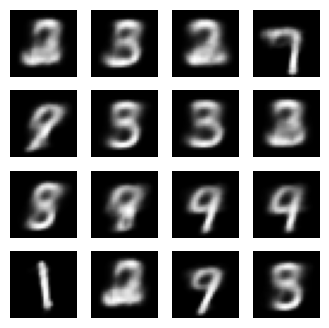

In [45]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [46]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

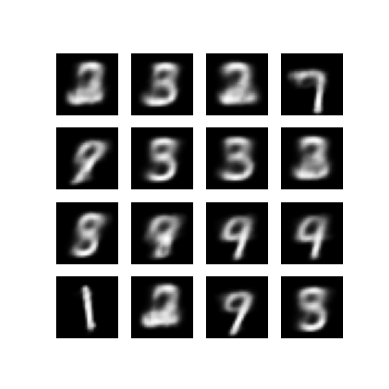

In [47]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [48]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-48-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-48-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



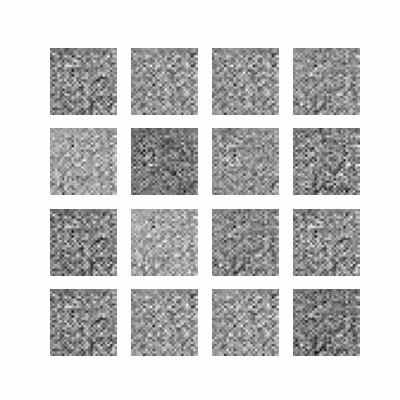

In [49]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [50]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

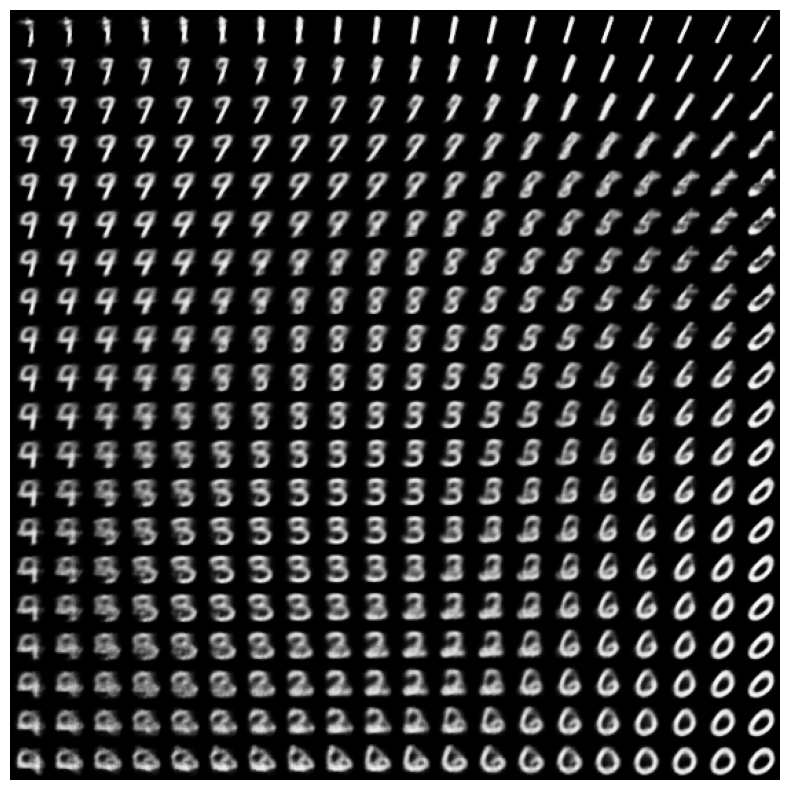

In [51]:
plot_latent_images(model, 20)

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow.

As a next step, you could try to improve the model output by increasing the network size.
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512.
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).